# Importation des données 

In [3]:
#encoding: utf-8
from scipy.io import arff
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd
import seaborn as sns
import time
import os
import csv
import hdbscan
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


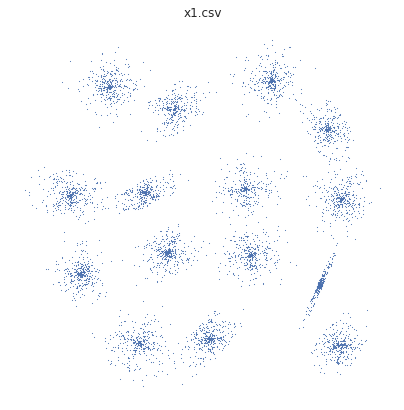

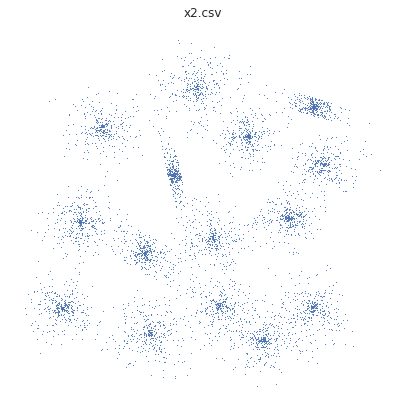

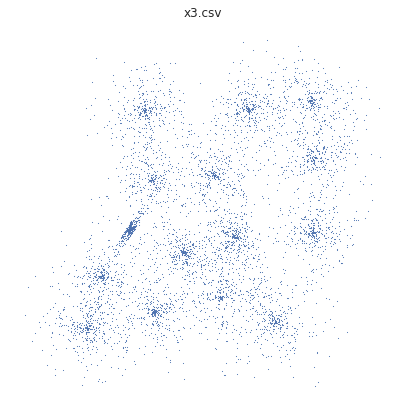

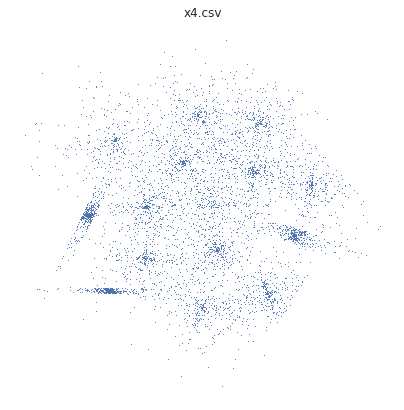

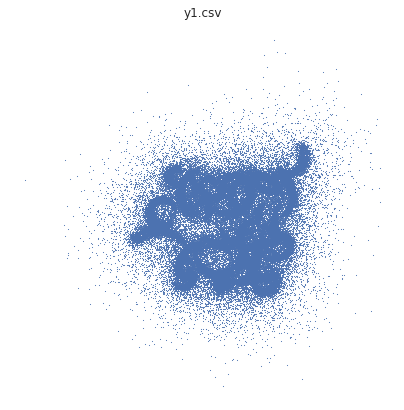

In [4]:
path = 'clustering-iris-dataset/'
#X1 = np.genfromtxt(path+'x1.csv', delimiter=';') 
names = ['x1', 'x2', 'x3', 'x4', 'y1']


import pandas as pd
datasets = []
for filename in names :
    df = pd.read_csv(path+filename+'.csv', delimiter=';')
    datasets.append(df)
    #datasets[-1].plot(kind='scatter', x='x', y='y', title= filename+'.csv')


    fig = plt.figure(figsize=[7,7])
    data = np.array([(x,y) for x,y in zip(df["x"],df["y"])])
    plt.scatter(data.T[0], data.T[1],linewidths =0,s=1.2)
    plt.title(filename+'.csv')
    plt.axis("off")
    plt.show()
# Apply KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN on the data

In [88]:
def plot_4labels(labels,legends,methode,sampley):
    n = len(labels)
    fig = plt.figure(figsize=[3*n,5])
    #fig = plt.figure(figsize=[15,15])
    for i in range(n):
        data_brutes = arff.loadarff(open(sampley[i],'r'))[0]    
        data = np.array([(x,y) for x,y in zip(sampley[i]["x"],sampley[i]["y"])])
        print(sampley[i])
        print(data.shape, n, len(labels),data.T[0])
        plt.subplot(1,n,i+1)
        palette = sns.color_palette("hls", np.max(labels[i])+2)
        cluster_colors = [palette[col] for col in labels[i]]
        plt.axis("equal")
        plt.scatter(data.T[0], data.T[1], c=cluster_colors,linewidths =0,s=12)#s=1.2)
        plt.axis("off")
        plt.title(legends[i], y=-0.55)
    plt.tight_layout()
    fig.savefig("images/"+methode+".png")
    plt.show()

In [76]:
lelabel = []
lelegend = []

def k_optimiser(algo,datasets,names,nom,**kwargs):
    global lelabel, lelegend
    labels = []
    legends = [] 
    for data_brutes,name in zip(datasets[4:],names[4:]):
        data = np.array([(x,y) for x,y in zip(data_brutes["x"],data_brutes["y"])])
        params = []
        silhs = []
        #print(data.shape)
        for k in range(23,24):#1-20
            tps1 = time.time()
            #model = KMeans(n_clusters=k, init='k-means++', random_state=0)
            model = algo(n_clusters=k, **kwargs) #linkage = single, average, complete, ward
            model.fit(data) 
            tps2 = time.time()
            try:
                silh = metrics.silhouette_score(data, model.labels_, metric='euclidean')
            except:
                silh = -100
            params.append(k)
            silhs.append(silh)
        max_param = params[np.argmax(silhs)]
        #model = KMeans(n_clusters=max_param, init='k-means++', random_state=0)
        model = algo(n_clusters=max_param, **kwargs)
        model.fit(data)
        try:
            silh = metrics.silhouette_score(data, model.labels_, metric='euclidean')
            davies_b = metrics.davies_bouldin_score(data, model.labels_)
        except:
            silh = -100
            davies_b = -100
        labels.append(model.labels_)
        legends.append(name+"\nnb_cluster = $"+str(np.max(model.labels_)+1)+"$\nruntime = $"+str(round((tps2 - tps1)*1000,2))+"$ ms"+"\nsilh_score = $"+str(round(silh,2))+"$"+"\ndavies_score = $"+ str(round(davies_b,2))+"$")
    lelabel, lelegend = labels, legends
    plot_4labels(labels,legends,nom,datasets[4:])

In [59]:
def ms_eps_optimiser(algo,datasets,names,nom,**kwargs):
    #global datasets,names
    labels = []
    legends = []
    for data_brutes,name in zip(datasets[4:],names[4:]):
        data = np.array([(x,y) for x,y in zip(data_brutes["x"],data_brutes["y"])])
        params = []
        silhs = []
        #for ms in range(2,4):
        #    for eps_i in range(2,300):
        # DBSCAN testé de pour ms 2 à 100
        for ms in range(2,5):
            for eps_i in range(2,50):
                eps = eps_i/100
                tps1 = time.time()
                if nom == "HDBSCAN":
                    model = hdbscan.HDBSCAN(min_samples=ms,cluster_selection_epsilon=eps, **kwargs)
                    model.fit_predict(data)
                else:                    
                    model = algo(eps=eps,min_samples=ms, **kwargs)
                    model.fit(data)
                tps2 = time.time()
                try:
                    silh = metrics.silhouette_score(data, model.labels_, metric='euclidean')
                except:
                    silh = -100
                params.append((ms,eps))
                silhs.append(silh)
        print(silhs)
        max_param = params[np.argmax(silhs)]
        #model = DBSCAN(eps=max_param[1],min_samples=max_param[0], metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)

        if nom == "HDBSCAN":
            model = hdbscan.HDBSCAN(min_samples=max_param[0],cluster_selection_epsilon=max_param[1], **kwargs)
            model.fit_predict(data)
        else:
            model = algo(eps=max_param[1],min_samples=max_param[0], **kwargs)
            model.fit(data)
        try:
            silh = metrics.silhouette_score(data, model.labels_, metric='euclidean')
            davies_b = metrics.davies_bouldin_score(data, model.labels_)
        except:
            silh = -100
            davies_b = -100
        labels.append(model.labels_)
        legends.append(name+"\nnb_cluster = $"+str(np.max(model.labels_)+1)+"$\n(eps=$"+str(max_param[1])+"$, min-sample=$"+str(max_param[0])+"$)\nruntime = $"+str(round((tps2 - tps1)*1000,2))+"$ ms"+"\nsilh_score = $"+str(round(silh,2))+"$"+"\ndavies_score = $"+ str(round(davies_b,2))+"$")
    #print(labels[0])
    plot_4labels(labels,legends,nom,datasets[4:])

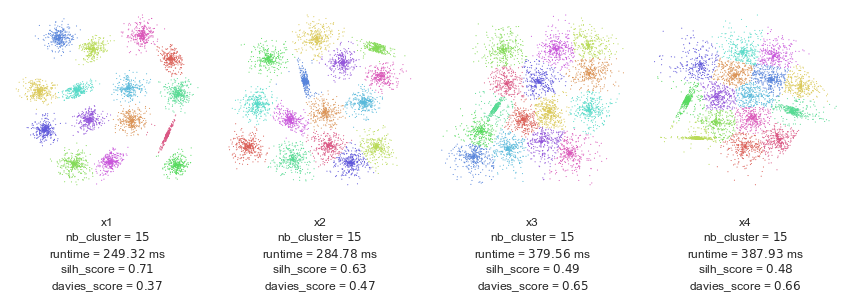

In [129]:
k_optimiser(KMeans, datasets, names, "KMEAN", init='k-means++', random_state=0)

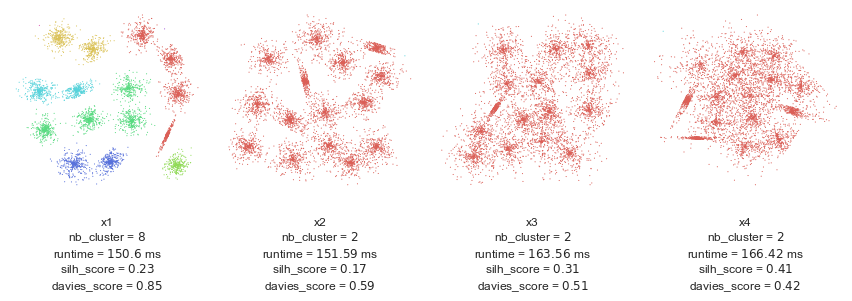

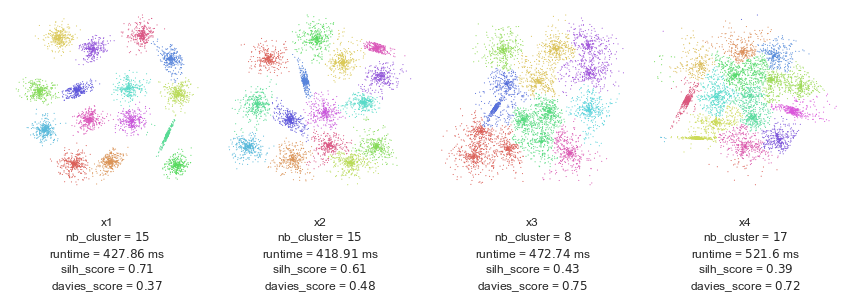

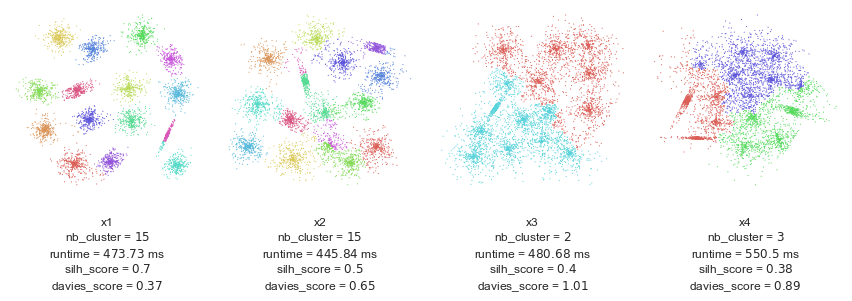

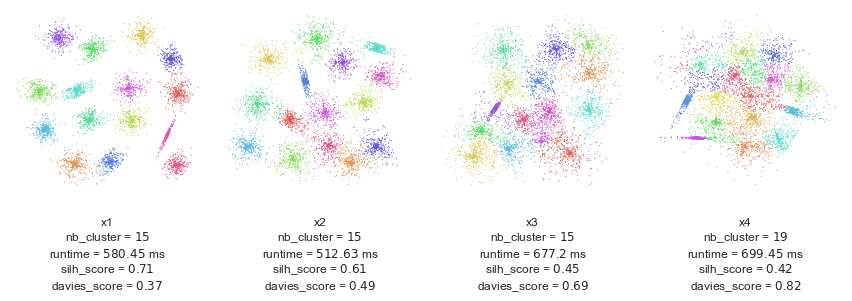

In [131]:
k_optimiser(AgglomerativeClustering, datasets, names, "AGG_SINGLE", affinity='euclidean', linkage='single')
k_optimiser(AgglomerativeClustering, datasets, names, "AGG_AVG", affinity='euclidean', linkage='average')
k_optimiser(AgglomerativeClustering, datasets, names, "AGG_COMPLETE", affinity='euclidean', linkage='complete')
k_optimiser(AgglomerativeClustering, datasets, names, "AGG_WARD", affinity='euclidean', linkage='ward')

[-1 -1 -1 ... -1 -1 -1]


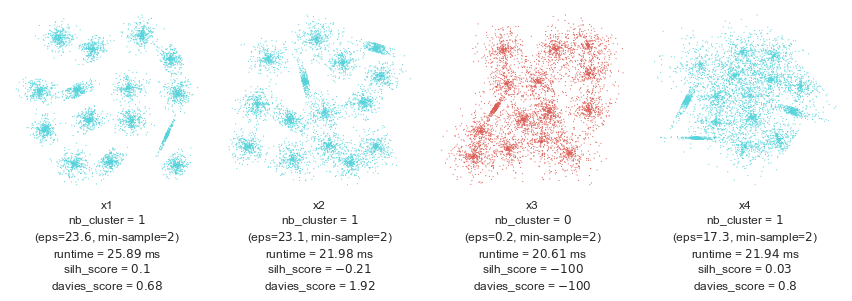

In [42]:
ms_eps_optimiser(DBSCAN, datasets, names, "DBSCAN", metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)

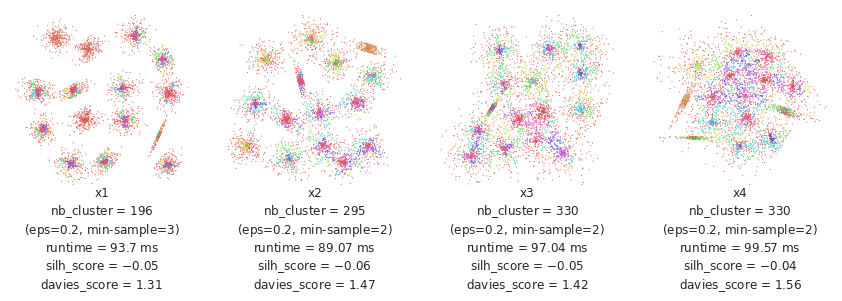

In [7]:
ms_eps_optimiser(hdbscan.HDBSCAN, datasets, names, "HDBSCAN")

In [ ]:
ms_eps_optimiser(hdbscan.HDBSCAN, datasets, names, "HDBSCAN")

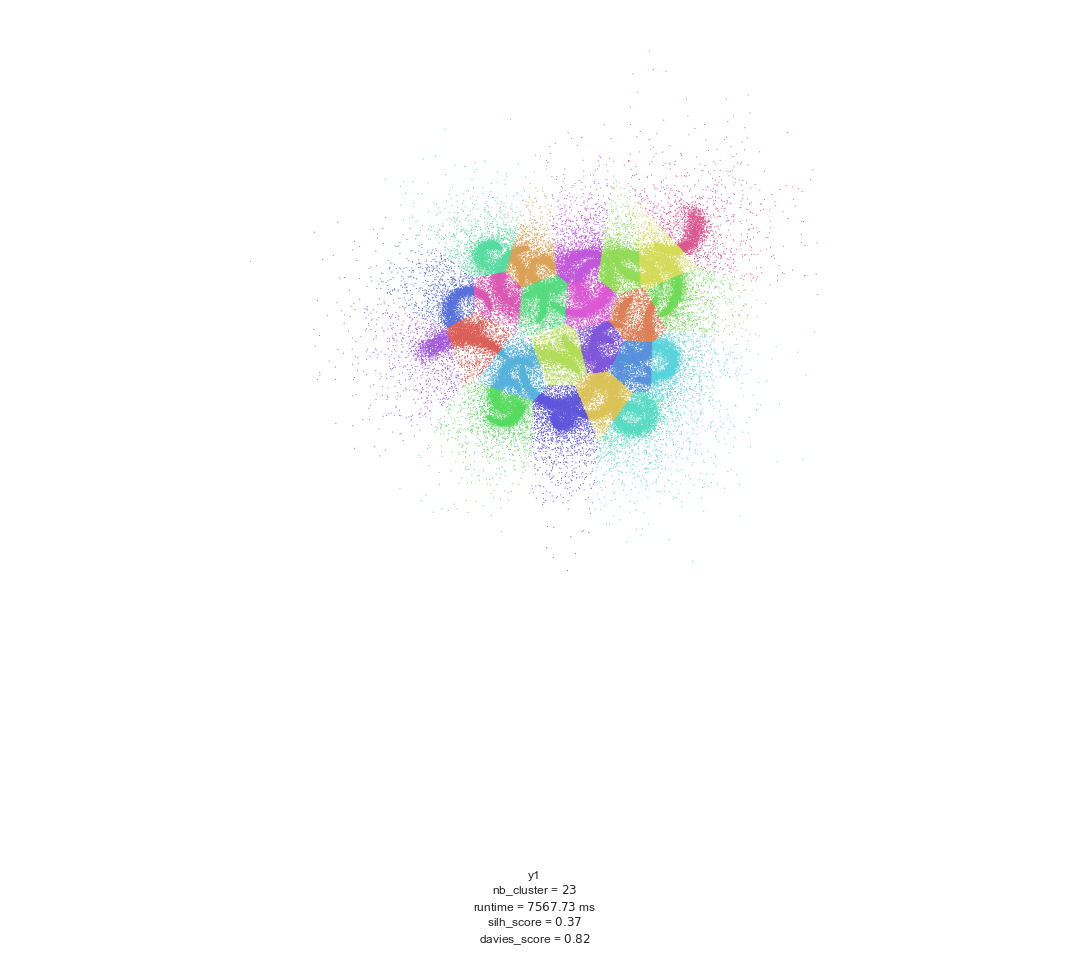

In [54]:
k_optimiser(KMeans, datasets, names, "KMEAN", init='k-means++', random_state=0)

In [56]:
k_optimiser(AgglomerativeClustering, datasets, names, "AGG_WARD", affinity='euclidean', linkage='ward')

MemoryError: unable to allocate array data.

[-0.780771172910343, -0.780771172910343, -0.780771172910343, -0.780771172910343, -0.780771172910343, -0.780771172910343, -0.780771172910343, -0.780771172910343, -0.8764566475511105, -0.8962885375504723, -0.8962885375504723, -0.8962885375504723, -0.8962885375504723, -0.9121076072624883, -0.9121076072624883, -0.9121076072624883, -0.9121076072624883, -0.9121076072624883, -0.91911934961824, -0.924573728127114, -0.924573728127114, -0.9310330728286972, -0.9310330728286972, -0.9310330728286972, -0.9310330728286972, -0.9310330728286972, -0.9310330728286972, -0.9317282608402027, -0.9317688055947647, -0.9316434122783251, -0.9303855964726323, -0.9303855964726323, -0.9303855964726323, -0.9303855964726323, -0.9303855964726323, -0.9282145546582522, -0.9282145546582522, -0.9282145546582522, -0.9276776422180171, -0.9268979225407998, -0.923964991539295, -0.9228462642054616, -0.9228462642054616, -0.919576955714892, -0.919576955714892, -0.919576955714892, -0.919576955714892, -0.919576955714892, -100, -10

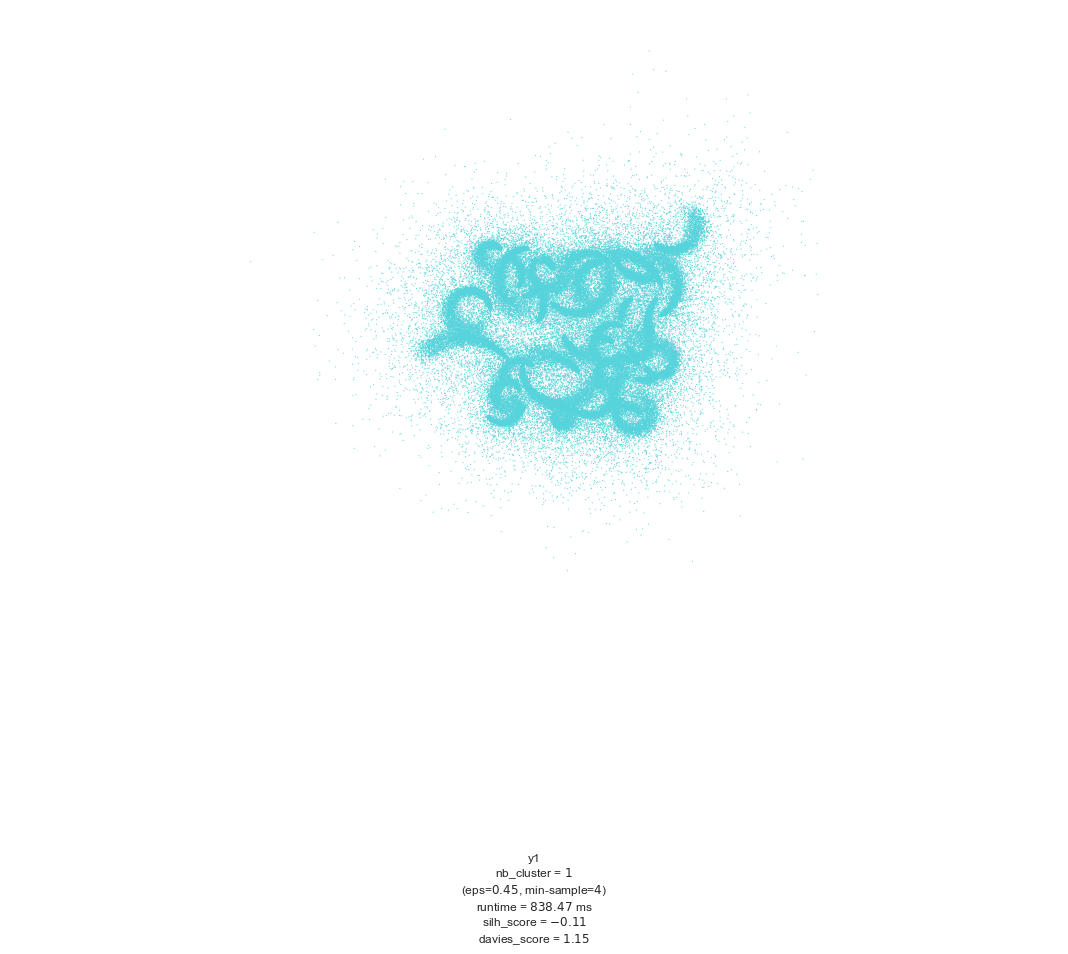

In [60]:
ms_eps_optimiser(DBSCAN, datasets, names, "DBSCAN", metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)

## Importation du jeu de données réel IRIS

In [90]:
#print(os.getcwd())
os.chdir("clustering-benchmark-master/src/main/resources/datasets/real-world")
data_brutes = arff.loadarff(open("iris.arff",'r'))[0]    
os.chdir("../../../../../..")
#print(os.getcwd())
#print(data_brutes)

irisets = [[(x[0],x[1]) for x in data_brutes],[(x[0],x[2]) for x in data_brutes],[(x[0],x[3]) for x in data_brutes],[(x[1],x[2]) for x in data_brutes],[(x[2],x[3]) for x in data_brutes]]